# <div class="alert alert-info">Imports and packages</div>

In [4]:
#!pip install akshare quantstats

import warnings
warnings.filterwarnings('ignore')
import time
import akshare as ak
import numpy as np
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import random
from myconfig import SqlConnManager
# %matplotlib inline

# <div class="alert alert-info">List of functions to be defined</div>
***
- get_ETF_data
- get_data_euqal_period_CSV
- get_data_euqal_period_SQL
- get_data_full_period
***
- rolling_optimization_table
- table_interpret
- performance_test_equal_period
***
- trial_optimization
- corr_test


In [31]:
def get_ETF_data(SecuCode):
    """
    
    :param SecuCode int/str
    
    :return ETF Data
    """
    sql = f"""SELECT * FROM [jydb].[dbo].SecuMain WHERE SecuCode = '{SecuCode}' """
    data = pd.read_sql(sql, SqlConnManager.conn_jy())
    InnerCode = data['InnerCode'][0]
    if len(data)>1:
        for row in range(len(data)):
            if data.iloc[row,:]['ChiNameAbbr'] != None:
                InnerCode = data.iloc[row,:]['InnerCode']
    sql2 = f"""SELECT 
                [InnerCode]
              ,[InfoPublDate]
              ,[InfoSource]
              ,[EndDate]
              ,[NV]
              ,[UnitNV]
              ,[AccumulatedUnitNV]
            FROM [jydb].[dbo].[MF_NetValue]
            where innercode = '{InnerCode}'  order by InfoPublDate ASC"""
    data2 = pd.read_sql(sql2, SqlConnManager.conn_jy())
    return data2

In [42]:
# Align all the DFs in list to the size of the shortest one 
def get_data_euqal_period_CSV(list_of_codes):
    """
    :param list_of_names:

    :return: DataFrame
    """
    # parameter type: list
    etf_list = []
    for i in list_of_codes:
        file_path = os.path.join(r"C:\Users\ps\PycharmProjects\pythonProject", f"{str(i)}.csv")
        etf_data = pd.read_csv(file_path)
        etf_data = etf_data[['EndDate', 'AccumulatedUnitNV']].set_index('EndDate')
        etf_data = etf_data.rename(columns={'AccumulatedUnitNV': f"etf_{str(i)}"})
        etf_list.append(etf_data)
        
        def compare_index_difference(df1, df2):
            index1 = set(df1.index)
            index2 = set(df2.index)

            missing_indices_df1 = index2 - index1
            missing_indices_df2 = index1 - index2

            return missing_indices_df1, missing_indices_df2
    
        

    shortest_length = len(etf_list[0]) + 1
    shortest_index = -1

    # Find the shortest DataFrame
    list_of_index = []
    for i, df in enumerate(etf_list):
        list_of_index.append(i)
        if len(df) < shortest_length:
            shortest_length = len(df)
            shortest_index = i


    # Align all length based on the shortest DF
    for i, df in enumerate(etf_list):
        if i == shortest_index:
            continue
        etf_list[i] = df.drop(compare_index_difference(df, etf_list[shortest_index])[1])

    data = pd.concat([etf_list[0], etf_list[1]], axis=1)
    
    for index in list_of_index[2:]:
        data = pd.concat([data, etf_list[index]], axis=1)
    data = data.dropna().iloc[:]
    data.index = pd.to_datetime(data.index)
    
    # 计算每日涨跌幅和滚动收益率
    for column in data.columns:
        data[f'{column}_day_return'] = data[column].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
    
    return data

In [43]:
# Align all the DFs in list to the size of the shortest one 
# Sometimes Direct Call SQL Will Be Exposed to Network Issues
def get_data_euqal_period_SQL(list_of_codes):
    """
    :param list_of_names:

    :return: DataFrame
    """
    # parameter type: list
    etf_list = []
    for i in list_of_codes:
        etf_data = get_ETF_data(i)
        etf_data = etf_data[['EndDate', 'AccumulatedUnitNV']].set_index('EndDate')
        etf_data = etf_data.rename(columns={'AccumulatedUnitNV': f"etf_{str(i)}"})
        etf_list.append(etf_data)
        
        
        def compare_index_difference(df1, df2):
            index1 = set(df1.index)
            index2 = set(df2.index)

            missing_indices_df1 = index2 - index1
            missing_indices_df2 = index1 - index2

            return missing_indices_df1, missing_indices_df2
    
        

    shortest_length = len(etf_list[0]) + 1
    shortest_index = -1
    # Find the shortest DataFrame
    list_of_index = []
    for i, df in enumerate(etf_list):
        list_of_index.append(i)
        if len(df) < shortest_length:
            shortest_length = len(df)
            shortest_index = i


    # Align all length based on the shortest DF
    for i, df in enumerate(etf_list):
        if i == shortest_index:
            continue
        etf_list[i] = df.drop(compare_index_difference(df, etf_list[shortest_index])[1])

    data = pd.concat([etf_list[0], etf_list[1]], axis=1)
    
    for index in list_of_index[2:]:
        data = pd.concat([data, etf_list[index]], axis=1)
    data = data.dropna().iloc[:]
    data.index = pd.to_datetime(data.index)
    
    # 计算每日涨跌幅和滚动收益率
    for column in data.columns:
        data[f'{column}_day_return'] = data[column].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
    
    return data

In [34]:
# Align all the DFs in list to the size of the shortest one 
def get_data_full_period(list_of_codes):
    """
    :param list_of_names:

    :return: DataFrame
    """
    # parameter type: list
    etf_list = []
    for i in list_of_codes:
        etf_data = get_ETF_data(i)
        etf_data = etf_data[['EndDate', 'AccumulatedUnitNV']].set_index('EndDate')
        etf_data = etf_data.rename(columns={'AccumulatedUnitNV': f"etf_{str(i)}"})
        etf_list.append(etf_data)
        
    
        

    longest_length = len(etf_list[0])
    longest_index = 0

    # Find the longest DataFrame
    list_of_index = []
    for i, df in enumerate(etf_list):
        list_of_index.append(i)
        if len(df) > longest_length:
            longest_length = len(df)
            longest_index = i
    

    # Align all length based on the shortest DF
    data = etf_list[longest_index]
    for i, df in enumerate(etf_list):
        if i == longest_index:
            continue
        data = pd.concat([data, df], axis=1)
    data.index = pd.to_datetime(data.index)
    data = data[:-1]

    
    # 计算每日涨跌幅和滚动收益率
    for column in data.columns:
        data[f'{column}_day_return'] = data[column].rolling(2).apply(lambda x:(x[-1]-x[0])/x[0])
    
    return data

In [36]:
################################# Convient W #########################################


def rolling_optimization_table(window_list, data, target_num):
    """
    :param window_list:
    :param data:
    :param target_num:

    :return: data_table
    """
    # parameter type: list, DataFrame, int
    
    data_table = pd.DataFrame()

    for i in window_list:
        data_x = data.copy()
        signal_name = []
        
        for num, name in enumerate(data_x.columns[target_num:]):
            data_x[f'{name}_{str(i)}'] = data_x[data_x.columns[num]].rolling(window=i).apply(lambda x: x[-1]/x[0])
            signal_name.append(f'signal_{data_x.columns[num][4:]}')
        
        data_x = data_x.iloc[i:,:]
        for name in signal_name:
            data_x[name] = [0] * len(data_x)
        
        for row in range(len(data_x)):
            value = data_x.iloc[row][2*target_num:3*target_num].max()
            series = data_x.iloc[row]
            try:
                position = series[2*target_num:3*target_num][series == value].idxmax()
            except:
                continue
            old_position = series.index.get_loc(position)
            new_position = old_position + target_num
            data_x.loc[data_x.index[row],series.index[new_position]] = 1
        
        for name in data_x.columns[-target_num:]:
            data_x[name] = data_x[name].shift(1)
        
        data_x = data_x[1:]
        
        data_x[f'signal_return_{str(i)}'] = [0] * len(data_x)
        arr = []
        X = target_num
        for row in range(len(data_x)):
            value = data_x.iloc[row][3*X:4*X].max()
            series = data_x.iloc[row]
            ## find the position of signal with 1 
            position = series[3*X:4*X][series == value].idxmax()
            old_position = series.index.get_loc(position)
            new_position = old_position - 2*X
            arr.append(series[new_position] + 1)
               
        data_x['arr'] = arr
        data_x[f'signal_return_{str(i)}'] = np.cumprod(arr, axis=0)*100

        data_x[f'signal_return_{str(i)}'] = (100/data_x[f'signal_return_{str(i)}'].values[0]) * data_x[f'signal_return_{str(i)}'] 
        data_table[f'signal_return_{str(i)}'] = data_x[f'signal_return_{str(i)}']
    return data_table

In [37]:
################################# Convient W #########################################

def table_interpret(data_table):
    """
    :param data_table: DataFrame
    :return: data_table
    """
    # Calculate strategy performance metrics
    result = {}
    metrics = ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]
    for column in data_table.columns:
        result[column] = []
        for metric in metrics:
            metric_function = getattr(qs.stats, metric)
            r = metric_function(data_table[column])
            result[column].append(r)

    result = pd.DataFrame(result, index=metrics)

    print(result)
    
    # Plot performance curves
    _ = plt.figure(figsize=(15, 10))
    plt.xlabel('Time') 
    plt.ylabel('Return')
    
    legend_list = []
    for name in data_table.columns:
        _ = plt.plot(np.array(data_table[name].index), data_table[name].values)
        legend_list.append(f'windows{name[-1]}_{result.loc["sharpe", name]}')
    _ = plt.legend(legend_list)
    
    ax = plt.gca()
    plt.title(f'Different Rolling Window size with their Sharpe Ratio on {len(data_table)} days since 2021-06', fontname='Arial', fontsize=21)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(250))


In [38]:
def performance_test_equal_period(list_of_codes, window_list):
    """
    :param list_of_codes:['512480', '159865', '588080', '515790', '515080']
    :param window_list:[3,6,9,12,15,18,21,24,27]

    """
    # parameter type: list, list
    
    data = get_data_full_period(list_of_codes)
    target_num = len(list_of_codes)
    data_table  = rolling_optimization_table(window_list, data, target_num)
    table_interpret(data_table)
    return None
    

In [53]:
def trial_optimization(list_of_all_codes, window_list, attempts_time, sample_size):
    """
    :param list_of_all_codes:['512480', '159869', '512170', '512690', '512980', 
                            '516950','159865', '588080', '515790', '515080']
    :param window_list:[3,6,9,12,15,18,21,24,27]
    :param attempts_time:100

    """
    # parameter type: list, list
    winner_codes = []
    bar_return = 100
    unique_codes = []
    for i in range(attempts_time):
        random_codes = random.sample(list_of_all_codes, sample_size)
        
        # Check if the new random_codes are already present in the set of unique codes
        n = 0
        while random_codes in unique_codes:
            random_codes = random.sample(list_of_all_codes, sample_size)
            n += 1
            if n >20:
                break
        
        # Add the new random_codes to the set of unique codes
        unique_codes.append(random_codes)
        
        data = get_data_full_period(random_codes)
        data_table  = rolling_optimization_table(window_list, data, int(len(data.columns)/2))
        last_row = data_table.iloc[-1]
        largest_value = last_row.max()
        largest_column = last_row.idxmax()
#         print(f'Áttempt No.{i+1} on combination {random_codes} got {round(largest_value,3)} return at Windows={largest_column[14:]}')
        if largest_value > bar_return:
            print(f'HOORAY! The new bar is set at {round(largest_value,3)}!!')
            bar_return = largest_value
            bar_column = largest_column
            winner_codes = random_codes
    print('***************************************************************************************')
    print('**********************************Result***********************************************')
    print(f'\n1)The optimized combination is {winner_codes}\n2)The max return from it is {bar_return} at  Windows={bar_column[14:]}')
    return None

In [18]:
def corr_test(list_of_all_codes, attempts_time, sample_size, display_num, window_list, method, comparison_target):
    """
    
    :param list_of_all_codes:['512480', '159869', '512170', '512690', '512980']
    :param attempts_time:1000
    :param sample_size:2
    :param display_num:100
    :param window_list:[3,6,9,12,15,18,21,24,27]
    :param method: 1. 'equal_peiord_csv'; 2. 'equal_peiord_sql'; 3. 'full_period'
    
    :return the top No. of combo with lowest correlation and their corresponding return, Sharpe, and Windows
    """
    # parameter type: list, list
    winner_corr = {}
    unique_codes = []
    
    for i in range(attempts_time):
        random_codes = random.sample(list_of_all_codes, sample_size)
        
        # Check if the new random_codes are already present in the set of unique codes
        n = 0
        while random_codes in unique_codes:

            random_codes = random.sample(list_of_all_codes, sample_size)
            n += 1
            if n >10:
                break
        
        # Add the new random_codes to the set of unique codes
        unique_codes.append(random_codes)
        
        data = get_data_full_period(random_codes)
        if method == 'equal_peiord_csv':
            data = get_data_euqal_period(random_codes)
        if method == 'equal_peiord_sql':
            data = get_data_euqal_period_new(random_codes)
            
        # Daily Return Correlation
        data = data.iloc[1:,:].iloc[:,:sample_size]
        
        # Price Correlation
        if comparison_target == 'Price':
            data = data.iloc[1:,:]
        correlation = abs(data[data.columns[0]].corr(data[data.columns[1]]))

        if len(winner_corr) > display_num - 1:
            if correlation > list(winner_corr.keys())[-1]:
                continue
            # Remove the last key-value pair
            winner_corr.popitem()
        winner_corr[correlation]=random_codes
        # Sort the dictionary based on keys
        winner_corr = dict(sorted(winner_corr.items()))
    print('********************************************************************************')
    print(f'Here are the Top {len(winner_corr.keys())} Combination with the lowest correlation score')
    

    plot_corr = []
    plot_Sharpe = []
    plot_return = []
    for rank, correlation_score in enumerate(winner_corr.keys()):
        
        data = get_data_full_period(winner_corr[correlation_score])
        if method == 'equal_peiord_csv':
            data = get_data_euqal_period(winner_corr[correlation_score])
        if method == 'equal_peiord_sql':
            data = get_data_euqal_period_new(winner_corr[correlation_score])
            
        data_table  = rolling_optimization_table(window_list, data, 2)
        last_row = data_table.iloc[-1]
        largest_value = last_row.max()
        largest_column = last_row.idxmax()
        plot_corr.append(round(correlation_score,3))
        plot_return.append(round(largest_value,3))
        
        # Calculate strategy performance metrics
        result = {}
        metrics = ["avg_return", "volatility", "sharpe", "max_drawdown", "win_rate"]
        

        
        for column in data_table.columns:
            result[column] = []
            for metric in metrics:
                metric_function = getattr(qs.stats, metric)
                r = metric_function(data_table[column])
                result[column].append(r)

        result = pd.DataFrame(result, index=metrics)
        plot_Sharpe.append(round(result.loc["sharpe", largest_column],3))
        
        print(f'No.{rank+1}: {winner_corr[correlation_score]} with a score of {round(correlation_score,3)} and its max return is {round(largest_value,3)} with Sharpe {round(result.loc["sharpe", largest_column],3)} at Windows={largest_column[14:]}')
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    # Left subplot
    axs[0].scatter(plot_corr, plot_Sharpe)
    axs[0].set_title(f'Correlation vs. Sharpe on Windows={largest_column[14:]}')

    # Right subplot
    axs[1].scatter(plot_corr, plot_return)
    axs[1].set_title(f'Correlation vs. Return on Windows={largest_column[14:]}')

    plt.show()

    
    return None

# <div class="alert alert-info">Instructions</div>

***
### <div class="alert alert-success">1) Get Basic Data on Price and Daily Return from the selected ETF Data Combination </div>

<img src="579d9f0ba36a4e9a77362e6fe735fd2.png">

- **get_data_full_period(list_of_codes):** Live Data is obtained through SQL start from the first available trading date

- **get_data_euqal_period_CSV(list_of_codes):** Local Data is obtained through CSV will be trimmed to the same period based on the shortest ETF in the list
- **get_data_euqal_period_SQL(list_of_codes):** Live Data is obtained through SQL will be trimmed to the same period based on the shortest ETF in the list
***
### <div class="alert alert-success">2) Get The Best Window Performance from the selected ETF Data Combination </div>

<img src="560b31ba7d892164f87be33d2b18a11.png" width="700" height="700">

- **rolling_optimization_table(window_list, data, target_num)：** Return multiple signal_return based on the required window sizes in the window list
***
### <div class="alert alert-success">3) Get Sharpe results and return plot</div>
<img src="1acfbd9df74d85b5d47f7febf3837b2.png" width="700" height="700">


- **table_interpret(data_table):** Return Sharpe results and plot out returns over time
- **performance_test_equal_period(list_of_codes, window_list):** A shortcut to directly see the Sharpe and Returns with inputs of list_of_codes and window_list


***
### <div class="alert alert-success">4) Get the optimized combination from the list of ETFs based on the highest return</div>
<img src="7327fc9009dad99d393c3d45028139f.png" width="700" height="700">


- **trial_optimization(list_of_all_codes, window_list, attempts_time, sample_size):** Return the combination sample of ETFs that produces the highest return



***
### <div class="alert alert-success">5) Rank the randomized ETF combo based on their correlation (either Daily Return or Price) along with Return overtime and Sharpe</div>
<img src="8400f2b44165423c409f3aae271105d.png" width="700" height="700">

- **corr_test(list_of_all_codes, attempts_time, sample_size, display_num, window_list, method)**: run the correlation test to observe relationships and trend. The Correlation rank method can be changed to either Daily Return or Price; The Data Processing method can also be selected.

# <div class="alert alert-info">Attempts</div>

              signal_return_3  signal_return_6  signal_return_9  \
avg_return           0.001107         0.001301         0.001308   
volatility           0.373222         0.379939         0.385634   
sharpe               0.745786         0.858487         0.847748   
max_drawdown        -0.414516        -0.360455        -0.371870   
win_rate             0.510725         0.515369         0.500514   

              signal_return_12  signal_return_15  signal_return_18  \
avg_return            0.001640          0.000909          0.000720   
volatility            0.389927          0.388618          0.387129   
sharpe                1.047850          0.580866          0.460349   
max_drawdown         -0.353463         -0.523413         -0.626591   
win_rate              0.508247          0.490176          0.489627   

              signal_return_21  signal_return_24  signal_return_27  
avg_return            0.001460          0.001529          0.001529  
volatility            0.386602        

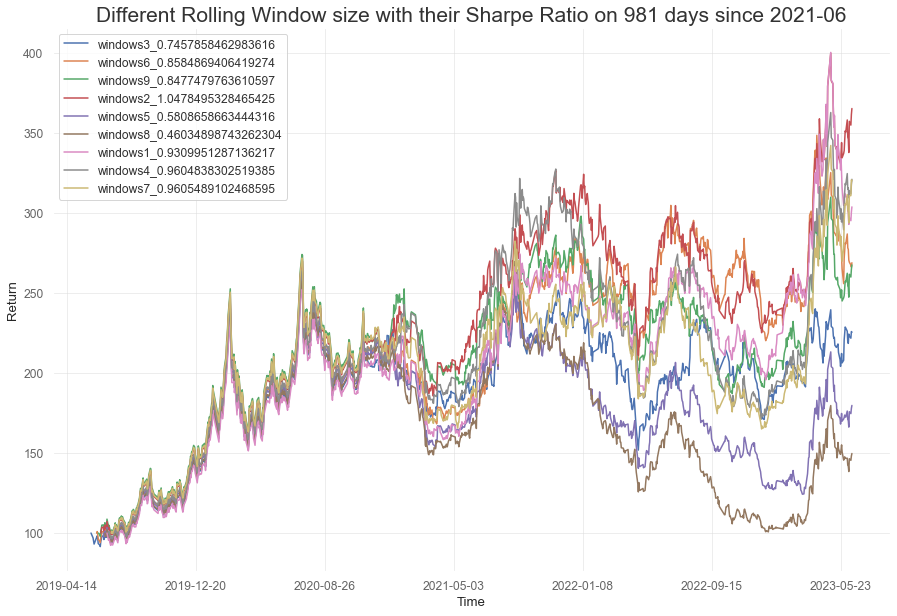

In [57]:
list_of_codes = ['512480', '159865', '588080', '515790', '159869']
window_list = [3,6,9,12,15,18,21,24,27]
performance_test_equal_period(list_of_codes, window_list)

In [56]:
list_of_all_codes = ['512480', '159869', '512170', '512690', '512980','516950','159865', '588080', '515790', '515080']
window_list = [3,6,9,12,15,18,21,24,27]
attempts_time = 30
sample_size = 2

trial_optimization(list_of_all_codes, window_list, attempts_time, sample_size)

HOORAY! The new bar is set at 135.986!!
HOORAY! The new bar is set at 337.456!!
HOORAY! The new bar is set at 400.965!!
HOORAY! The new bar is set at 437.658!!
***************************************************************************************
**********************************Result***********************************************

1)The optimized combination is ['159869', '512480']
2)The max return from it is 437.65752736504595 at  Windows=6


********************************************************************************
Here are the Top 49 Combination with the lowest correlation score
No.1: ['512170', '159869'] with a score of 0.008 and its max return is 273.996 with Sharpe 0.941 at Windows=21
No.2: ['159865', '512480'] with a score of 0.037 and its max return is 229.772 with Sharpe 0.778 at Windows=21
No.3: ['159967', '159869'] with a score of 0.051 and its max return is 393.313 with Sharpe 1.236 at Windows=21
No.4: ['516950', '512170'] with a score of 0.061 and its max return is 192.42 with Sharpe 0.74 at Windows=21
No.5: ['512980', '159865'] with a score of 0.061 and its max return is 100.566 with Sharpe 0.15 at Windows=21
No.6: ['515080', '512170'] with a score of 0.069 and its max return is 214.888 with Sharpe 0.956 at Windows=21
No.7: ['515790', '588080'] with a score of 0.088 and its max return is 93.161 with Sharpe 0.061 at Windows=21
No.8: ['512690', '516950'] with a score of 0.098 and its max return is 265.269 w

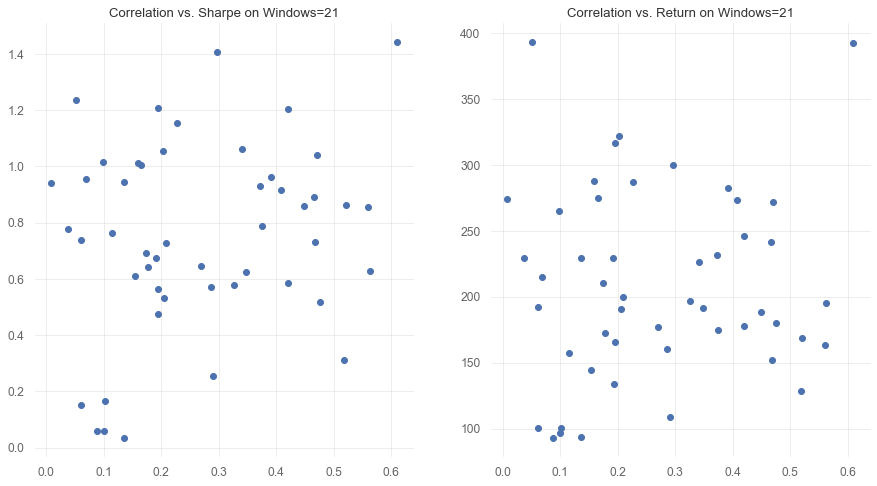

In [59]:
list_of_all_codes = ['512480', '159869', '512170', '512690', '512980','516950','159865', '588080', '515790', '515080', '159967', '512890']
attempts_time = 200
sample_size = 2
display_num = 50
window_list = [21]
method = 'full_period'
comparison_target = 'Price'


corr_test(list_of_all_codes, attempts_time, sample_size, display_num, window_list, method, comparison_target)